In [1]:
# Data manipulation
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML Models 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

# Model Metrics
from sklearn.metrics import accuracy_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set pyplot style
plt.style.use('seaborn')

# Dimensionality Reduction
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

In [2]:
# Import dataset from datasets directory
weightheight = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/weightheight.csv')
weightheight.head()

Gender  weight_kg  stature_m  body_height
0   Male       81.5      1.776        69.92
1   Male       72.6      1.702        67.01
2   Male       92.9      1.735        68.31
3   Male       79.4      1.655        65.16
4   Male       94.6      1.914        75.35

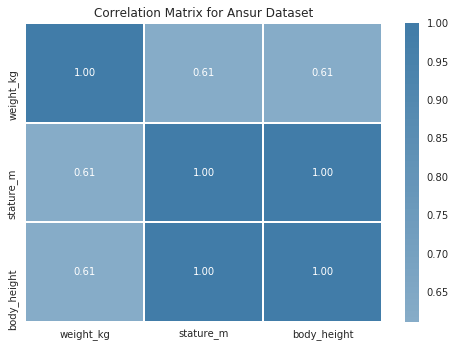

In [3]:
# Spot perfect correlation in data
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
sns.heatmap(weightheight.corr(), center=0, cmap=cmap, linewidths=1, annot=True, fmt='.2f')
plt.title('Correlation Matrix for Ansur Dataset')
plt.show()

In [4]:
# Brute force removal of hightly correlated features
abs_corr_matrix = weightheight.corr().abs()

# Upper triagule of corr matrix to false
mask = np.triu(np.ones_like(abs_corr_matrix, dtype=bool))
tri_df = abs_corr_matrix.mask(mask)

# Filter highly correlated dimensions
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]

# Drop highly correlated dimensions
reduced_df = weightheight.drop(to_drop, axis=1)

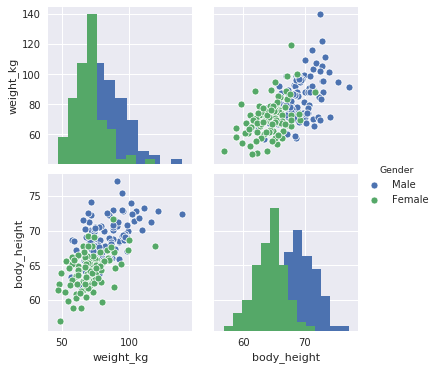

In [5]:
# Check visualization
sns.pairplot(reduced_df, hue='Gender', diag_kind='hist')
plt.show()

In [6]:
# High dimensional data import
ansur = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/ansur.csv')
ansur.drop('ID', axis=1, inplace=True)
print(f'Number of dimensions (cols): {len(ansur.columns)}')

Number of dimensions (cols): 94


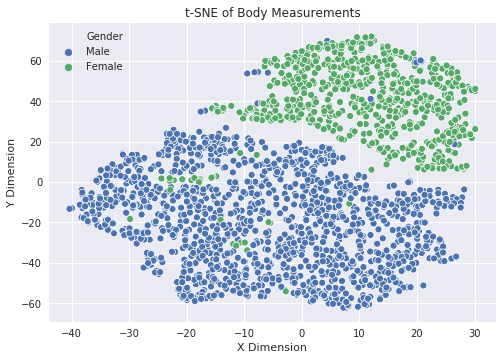

In [7]:
# Instanciate TSNE Model
tsne_model = TSNE(learning_rate=50)

# Fit and transform numeric data from 4th column
tsne_features = tsne_model.fit_transform(ansur.iloc[:, 4:])

# Add components to df
ansur['x'] = tsne_features[:, 0]
ansur['y'] = tsne_features[:, 1]

# Plot transformed data
sns.scatterplot(x='x', y='y', hue='Gender', data=ansur)
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.title('t-SNE of Body Measurements')
plt.show()

In [8]:
# Predict 'Gender' based on all body measurements
y = ansur['Gender']
X = ansur.drop(['Branch', 'Component', 'Gender', 'x', 'y'], axis=1)

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC()
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')


acc_train = 0.9714285714285714
acc_test = 0.9666666666666667


In [9]:
# Predict Gender based on 'neckcircumferencebase' feature 
y = ansur['Gender']
X = ansur[['neckcircumferencebase']]

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC()
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9342857142857143
acc_test = 0.9316666666666666


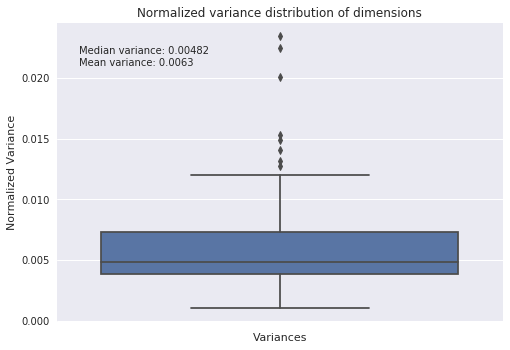

In [10]:
# Study the distribution of the variances from all dimensions from ansur

# Normalize columns for better visualization
numeric_dims = ansur.iloc[:, 3:-2] / ansur.iloc[:, 3:-2].mean()

# Calculate variances, median and mean
vars = numeric_dims.std() ** 2
median = round(vars.quantile(), 5)
mean = round(vars.mean(), 5)

# Plot variance distribution and annotate
sns.boxplot(y=vars.values)
plt.annotate(f'Median variance: {median}', (-0.45, 0.022))
plt.annotate(f'Mean variance: {mean}', (-0.45, 0.021))

plt.xlabel('Variances')
plt.ylabel('Normalized Variance')
plt.title('Normalized variance distribution of dimensions')
plt.show()


In [11]:
# Reduce dimensionality with a variance threshold (median variance)
variance_selection = VarianceThreshold(threshold=0.00482)

# Fit variance selector
variance_selection.fit(numeric_dims)

# Get variance mask
mask = variance_selection.get_support()

# Reduced ansur
reduced_ansur = numeric_dims.loc[:, mask]

# New number of dimensions
print(f'Old dimensions: {len(ansur.columns)}')
print(f'New dimensions: {len(reduced_ansur.columns)}')

Old dimensions: 96
New dimensions: 45


In [12]:
# Predict Gender based on reduced dataset
y = ansur['Gender']
X = reduced_ansur

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC(C=0.1)
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9978571428571429
acc_test = 1.0


In [13]:
# Predict Gender with a classifier less prone to overfit (simpler model)
log_reg = LogisticRegression(solver='newton-cg', C=0.1)

# Fit Model
log_reg.fit(X_train, y_train)

# Measure Accuracy
acc_train = accuracy_score(y_train, log_reg.predict(X_train))
acc_test = accuracy_score(y_test, log_reg.predict(X_test))

# Measure overfitting
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9778571428571429
acc_test = 0.98


In [14]:
# Create DataFrame of dimensions and coefficients
lr_coefs = dict(zip(reduced_ansur.columns, np.abs(log_reg.coef_[0])))

# Get absolute values for coefficients
coeffs = np.abs(log_reg.coef_[0])
coeffs = pd.Series(data=coeffs, index=reduced_ansur.columns)

# Sort coefficients by importance
coeffs.sort_values(ascending=False).head(5)

neckcircumference             1.585882
lateralmalleolusheight        1.355611
neckcircumferencebase         1.322256
hipbreadthsitting             1.217004
forearmcircumferenceflexed    1.155597
dtype: float64

In [15]:
# Instanciate and fit a Recursive Feature Elimination
rfe = RFE(estimator=log_reg, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Sort ranked features by incresing importance
feature_ranking = dict(zip(X.columns, rfe.ranking_))
sorted_features = dict(sorted(feature_ranking.items(), key=lambda x: x[1], reverse=True))

# Order DataFrame and set X, y
ranking_df = reduced_ansur[sorted_features.keys()]
X, y = ranking_df, ansur['Gender']

In [16]:
# Save accuracy scores
accuracy = []

# Iterate over all models
for i in range(len(sorted_features)):

    # Train Test Split with ordered features
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, i:], y, train_size=0.7, random_state=12)

    # Train model with those features
    log_reg.fit(X_train, y_train)

    # Measure accuracy
    train_acc = accuracy_score(y_train, log_reg.predict(X_train))
    test_acc = accuracy_score(y_test, log_reg.predict(X_test))
    accuracy.append([len(X_train.columns), train_acc, test_acc])

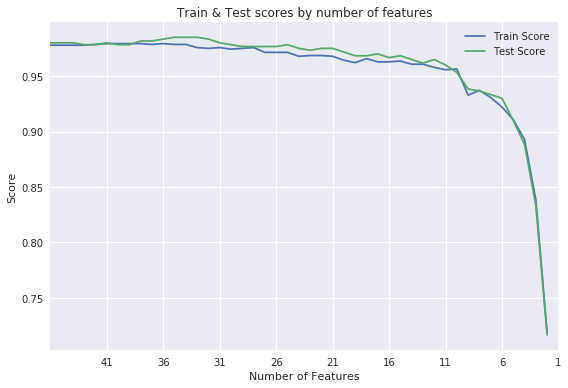

In [17]:
# Extract accuracy data from experiment
accuracy = np.array(accuracy)
features, train, test = np.split(accuracy, 3, axis=1)
features = features.flatten().astype('int')

# Plot lines of training adn testing accuracy
plt.plot(train, label='Train Score')
plt.plot(test, label='Test Score')
plt.xticks(features[::5], features[::-5])

# Annotate figure
plt.title('Train & Test scores by number of features')
plt.ylabel('Score')
plt.xlabel('Number of Features')

# Figure style and legend
plt.xlim(0, 45)
plt.tight_layout()
plt.legend()
plt.show()

In [18]:
# Import High Dimensional Data
diabetes = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/diabetes.csv', index_col='index')

# Set X and y
X = diabetes.drop(['diagnostic'], axis=1)
y = diabetes['diagnostic']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

# Feature selection with Tree Based Models
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Measure Accuracy
acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_test = accuracy_score(y_test, rf.predict(X_test))

# Sort important features
features = pd.Series(data=rf.feature_importances_.round(2), index=X.columns)
print(features.sort_values(ascending=False), '\n')

# Measure accuracy
print(f'{acc_train = }')
print(f'{acc_test = }')

glucose      0.27
insulin      0.15
age          0.12
bmi          0.12
family       0.11
triceps      0.08
diastolic    0.08
pregnant     0.07
dtype: float64 

acc_train = 1.0
acc_test = 0.7755102040816326


In [19]:
# Set X and y
X = diabetes.drop(['diagnostic', 'bmi'], axis=1)
y = diabetes['bmi']

# Train Test Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# Create the Lasso model and fit to data
la = Lasso(alpha=0.05)
la.fit(X_train_std, y_train)

# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = la.score(X_test_std, y_test)
print(f"Model predicted {r_squared:.2%} of the variance.")

# Create a list that has True values when coefficients equal 0
zero_coef = la.coef_ == 0

# Calculate how many features have a zero coefficient
n_ignored = sum(zero_coef)
print(f"The model has ignored {n_ignored} out of {len(la.coef_)} features.")

Model predicted 51.55% of the variance.
The model has ignored 0 out of 7 features.


In [20]:
from sklearn.linear_model import LassoCV
# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print(f'The model explains {r_squared:.1%} of the test set variance')

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print(f'{sum(lcv_mask)} features out of {len(lcv_mask)} selected')

Optimal alpha = 0.220
The model explains 51.0% of the test set variance
6 features out of 7 selected


In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=3, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

The model can explain 57.2% of the variance in the test set


In [22]:
from sklearn.ensemble import RandomForestRegressor

# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=10, step=3, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

The model can explain 54.8% of the variance in the test set


In [23]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 3

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

In [24]:
# Import Linear Model
from sklearn.linear_model import LinearRegression

# Create model
lm = LinearRegression()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

# Plug the reduced dataset into a linear regression pipeline
lm.fit(scaler.fit_transform(X_train), y_train)

# Measure accucary R^2
r_squared = lm.score(scaler.transform(X_test), y_test)

# Result
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

The model can explain 44.9% of the variance in the test set using 6 features.


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import dataset
ansur = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/ansur.csv')
ansur_df = ansur.drop(['Gender', 'Branch', 'Component', 'ID'], axis=1)

# Create the scaler
scaler = StandardScaler()
ansur_std = scaler.fit_transform(ansur_df)
n_components = 50

# Create the PCA instance and fit and transform the data with pca
pca = PCA(n_components=n_components)
pc = pca.fit_transform(ansur_std)
pc_df = pd.DataFrame(pc, columns=[f'PC_{x}' for x in range(1, n_components + 1)])

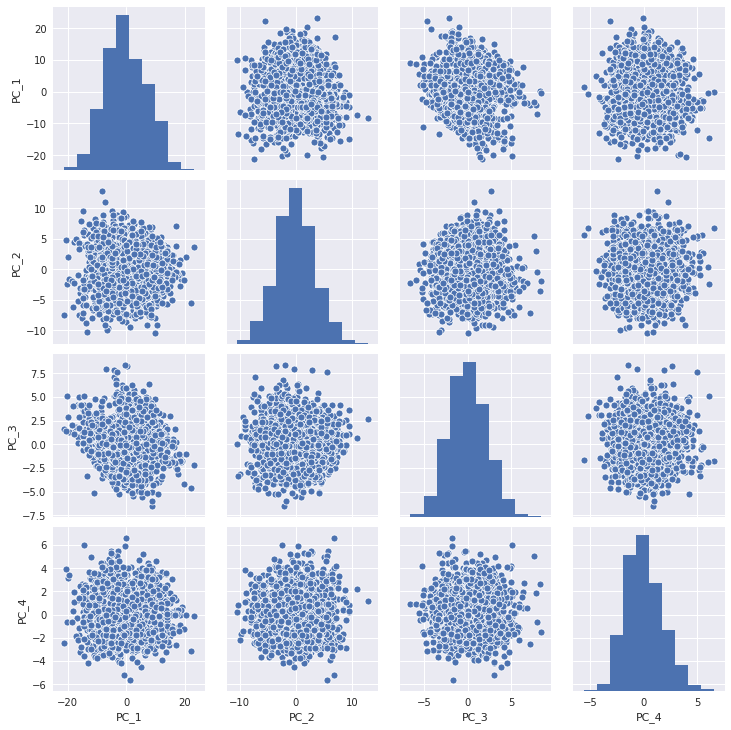

In [26]:
# Create a pairplot of the first n principal components
sns.pairplot(pc_df.iloc[:, :4])
plt.show()

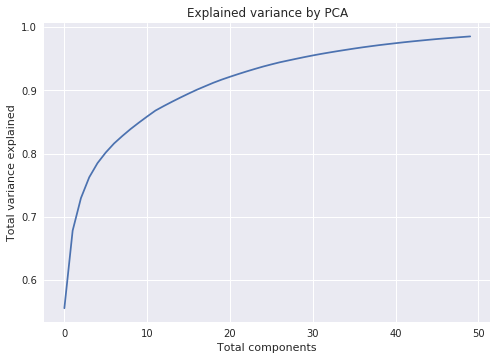

In [27]:
# Plot variance explanation by component
plt.plot(range(n_components), pca.explained_variance_ratio_.cumsum())

# Annotate plot
plt.title('Explained variance by PCA')
plt.xlabel('Total components')
plt.ylabel('Total variance explained')
plt.show()